# CellType classification model 

In [1]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

Import all the required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

from tensorflow import keras

Load mainData and extraData into dataframes

In [3]:
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')

mainData

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


In [4]:
mainData.cellTypeName.value_counts()

epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64

Check for any null values

Check if to see any null values exists

In [5]:
mainData.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

We remove the `InstanceID` column to prevent any data leaks and the `isCancerous` column since we are only predicting the cell type

In [6]:
mainData.drop(['InstanceID'], axis=1,inplace=True)
mainData.drop(['isCancerous'], axis=1,inplace=True)

In [7]:
print("#### mainData shape ####\n")
print(mainData.shape)
print("\n#### mainData info ####\n")
print(mainData.info())
print("\n#### mainData describe ####\n")
print(mainData.describe())

#### mainData shape ####

(9896, 4)

#### mainData info ####

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   patientID     9896 non-null   int64 
 1   ImageName     9896 non-null   object
 2   cellTypeName  9896 non-null   object
 3   cellType      9896 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 309.4+ KB
None

#### mainData describe ####

         patientID     cellType
count  9896.000000  9896.000000
mean     29.762025     1.501516
std      17.486553     0.954867
min       1.000000     0.000000
25%      14.000000     1.000000
50%      26.000000     2.000000
75%      47.000000     2.000000
max      60.000000     3.000000


Create a dictionary with label mapping for future predictions.

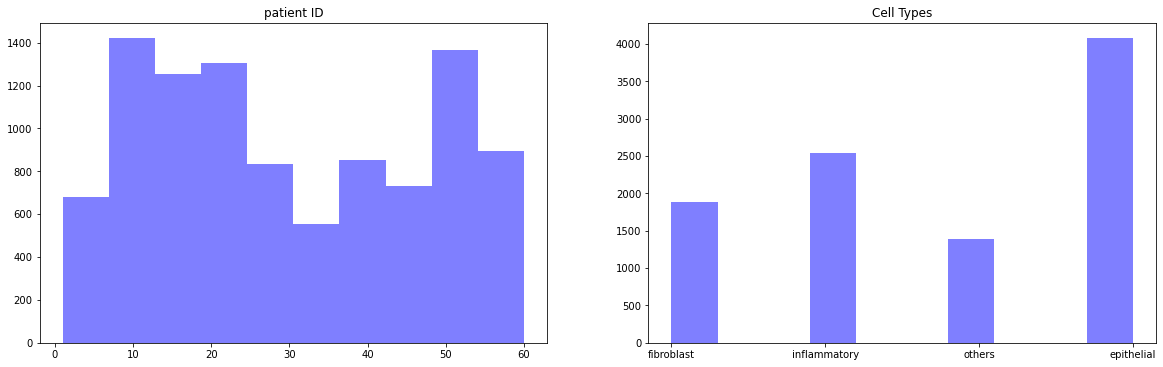

In [57]:
plt.figure(figsize=(20,20))
plt.subplot(3, 2, 1)
plt.hist(mainData['patientID'], facecolor='blue', alpha=0.5)
plt.title('patient ID')

plt.subplot(3, 2, 2)
plt.hist(mainData['cellTypeName'], facecolor='blue', alpha=0.5)
plt.title('Cell Types')
plt.show()

In [7]:
cellType_map = mainData.set_index('cellType').to_dict()['cellTypeName']

I noticed that there two cell type columns, one with the cell type name and a column containing a number for each corresponding cell type. Since this is available, we won't be required to One hot encode the cell type column.

In [8]:
mainData['cellType'] = mainData['cellType'].astype('category')
mainData['Class'] = mainData['cellType'].astype('str')

## Train test validation split

In [9]:
# Get list of patients and observation counts
TEST_RATIO = 0.10
VAL_RATIO = 0.15

In [10]:
np.random.seed(43) # Consistent random list

recCount = mainData.shape[0]
# Each occurance of patient corresponds to an image?
custRec = mainData.patientID.value_counts().to_dict()

patientIds = list(custRec.keys())

testCust = []
testRecs = 0
while (testRecs < (recCount * TEST_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    testCust.append(pId)
    testRecs += ic
    
valCust = []
valRecs = 0
while (valRecs < (recCount * VAL_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    valCust.append(pId)
    valRecs += ic

In [11]:
test_data = mainData[mainData.patientID.isin(testCust)]
val_data = mainData[mainData.patientID.isin(valCust)]
train_data = mainData[~(mainData.patientID.isin(valCust + testCust))]

In [12]:
print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 7096, Val Data: 1651, Test Data: 1149


In [13]:
train_data

,patientID,ImageName,cellTypeName,cellType,Class
0,1,22405.png,fibroblast,0,0
1,1,22406.png,fibroblast,0,0
2,1,22407.png,fibroblast,0,0
3,1,22408.png,fibroblast,0,0
4,1,22409.png,fibroblast,0,0
...,...,...,...,...,...
9891,60,1625.png,epithelial,2,2
9892,60,1626.png,epithelial,2,2
9893,60,1627.png,epithelial,2,2
9894,60,1628.png,epithelial,2,2


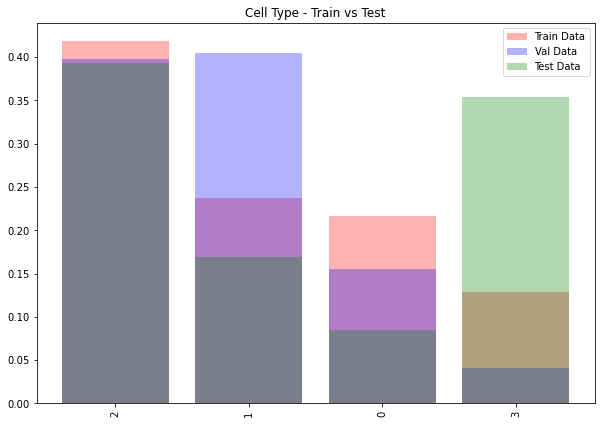

In [14]:
plt.figure(figsize=(10,7))
plt.bar(
    train_data.cellType.value_counts().index.astype(str), 
    train_data.cellType.value_counts().values/np.sum(train_data.cellType.value_counts().values), 
    alpha=0.3, 
    color='r',
    label='Train Data'
)
plt.bar(
    val_data.cellType.value_counts().index.astype(str), 
    val_data.cellType.value_counts().values/np.sum(val_data.cellType.value_counts().values), 
    alpha=0.3, 
    color='b',
    label='Val Data'
)
plt.bar(
    test_data.cellType.value_counts().index.astype(str), 
    test_data.cellType.value_counts().values/np.sum(test_data.cellType.value_counts().values), 
    alpha=0.3, 
    color='g',
    label='Test Data'
)

plt.title('Cell Type - Train vs Test')
plt.xticks(rotation='vertical')
plt.legend()

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale is done here to normalize the pixels in a range of 0-1
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# This the default batch size
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col = 'Class',
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col = 'Class',
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col = 'Class',
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 7096 validated image filenames belonging to 4 classes.
Found 1651 validated image filenames belonging to 4 classes.
Found 1149 validated image filenames belonging to 4 classes.


## Utility Functions

In [36]:
# Learning curve diagnostic tool
def plot_fit_history(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r')
    plt.plot(val_loss, 'b')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r')
    plt.plot(val_metric, 'b')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [37]:
def plot_confusion_matrix(test, pred):
    cm = confusion_matrix(test, test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# Baseline model

In [17]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4 # Flag for output layer

base_model = keras.Sequential([
    keras.layers.Flatten(input_shape=INPUT_DIM),
    keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    keras.layers.Dense(OUTPUT_CLASSES)
])

In [115]:
base_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 2187)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               560128    
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


In [116]:
base_model.compile(optimizer='SGD',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['categorical_accuracy'])

In [117]:
print("Training started...")
now = datetime.datetime.now()

base_histroy = base_model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

print("Took: ", datetime.datetime.now() - now)

Training started...
Took:  0:01:55.145910


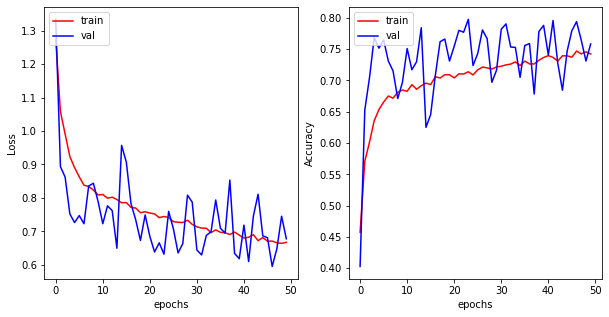

In [118]:
plot_learning_curve(base_histroy.history['loss'], base_histroy.history['val_loss'],
                    base_histroy.history['categorical_accuracy'], base_histroy.history['val_categorical_accuracy'])

Trying some regularization

In [18]:
reg_lambda = 0.01

reg_model = keras.Sequential([
    keras.layers.Flatten(input_shape=INPUT_DIM),
    keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_lambda)),
    keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=keras.regularizers.l2(reg_lambda))
])

In [27]:
reg_model.compile(optimizer='SGD',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [28]:
reg_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


In [29]:
print("Training started...")
now = datetime.datetime.now()

reg_history = reg_model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

print("Took: ", datetime.datetime.now() - now)

18:56:26
19:02:06
Took =  0:05:40.008037


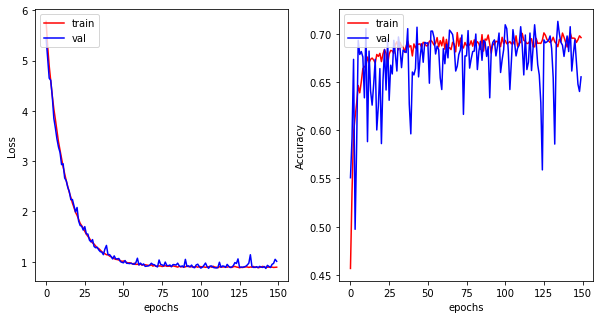

In [31]:
plot_learning_curve(reg_history.history['loss'], reg_history.history['val_loss'],
                    reg_history.history['categorical_accuracy'], reg_history.history['val_categorical_accuracy'])

## Base VGG model

In [32]:
VGG_model = keras.Sequential([
    #VGG block 1
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_lambda)),
    keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=keras.regularizers.l2(reg_lambda))
])

In [34]:
VGG_model.compile(optimizer='sgd',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [36]:
VGG_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)        

In [37]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

VGG_history = VGG_model.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

19:10:15
19:37:41
Took =  0:27:25.717075


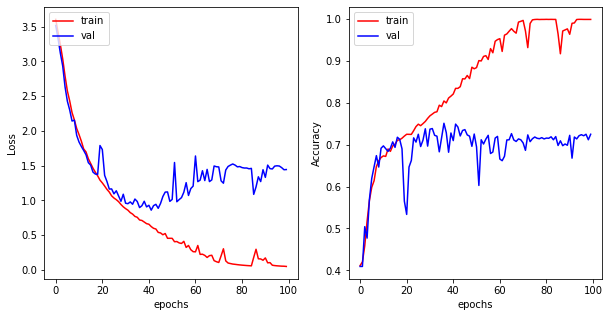

In [38]:
plot_fit_history(VGG_history.history['loss'], VGG_history.history['val_loss'],
                    VGG_history.history['categorical_accuracy'], VGG_history.history['val_categorical_accuracy'])

 Model seems to be overfitting.

In [45]:
VGG_model2 = keras.Sequential([
    #VGG block 1
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
#     #VGG block 3
#     keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_lambda)),
    keras.layers.Dropout(.2),
    keras.layers.Dense(OUTPUT_CLASSES,
                       activation='relu',
                       kernel_regularizer=keras.regularizers.l2(reg_lambda))
])

In [40]:
VGG_model2.compile(optimizer='sgd',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['categorical_accuracy'])

In [41]:
VGG_model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 128)        

In [42]:
print("Training started...")
now = datetime.datetime.now()

VGG2_history = VGG_model2.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

print("Took = ", datetime.datetime.now() - now)

Training started...
Took =  0:16:00.812824


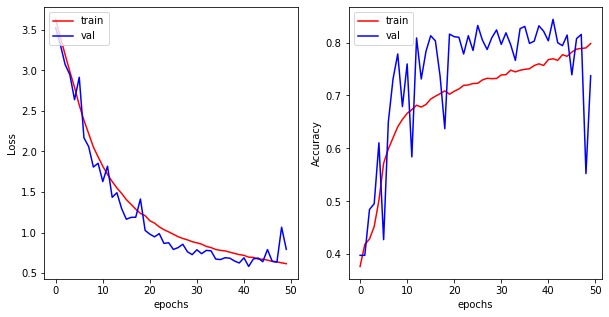

In [44]:
plot_fit_history(VGG2_history.history['loss'], VGG2_history.history['val_loss'],
                    VGG2_history.history['categorical_accuracy'], VGG2_history.history['val_categorical_accuracy'])

Performance seems slightly better, but definately can be imporved upon. As of right now, overfitting seems to be the main problem.

## Data Augumentation

In [55]:
aug_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
aug_val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

aug_train_generator = aug_train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col = "Class",
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'categorical'
)

aug_validation_generator = aug_val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col="Class",
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 7096 validated image filenames belonging to 4 classes.
Found 1651 validated image filenames belonging to 4 classes.


In [56]:
VGG_model2.compile(optimizer='sgd',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['categorical_accuracy'])

In [59]:
print("Training started...")
now = datetime.datetime.now()

VGG2_history = VGG_model2.fit(aug_train_generator, validation_data=aug_validation_generator, epochs=100, verbose=0)

print("Took = ", datetime.datetime.now() - now)

Training started...
Took =  0:27:54.584503


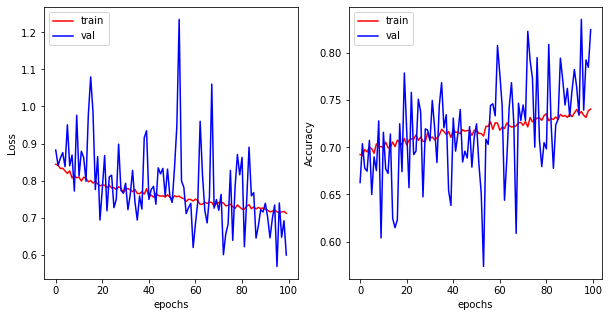

In [60]:
plot_fit_history(VGG2_history.history['loss'], VGG2_history.history['val_loss'],
                    VGG2_history.history['categorical_accuracy'], VGG2_history.history['val_categorical_accuracy'])